# Data Science Project assignment 2 with spark

In [1]:
# importing libraries 

import pyspark
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
conf = SparkConf().setAppName("HoteslData").setMaster("local[*]")
sc = SparkContext.getOrCreate() 

In [2]:
# opening new spark session sql 
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
# read the csv we got from assignment number 1
Hotels_data_Changed = spark.read.csv("Hotels_data_Changed.csv",header=True,inferSchema=True)
## order the dataset2 by Dates
Hotels_data_Changed= Hotels_data_Changed.orderBy(["Snapshot Date", "Checkin Date"], ascending=[1, 1])
## create New DataFrame from dataeset2 that will contain the columns that we need (this is not the groupby table)
NewCol= Hotels_data_Changed.select('WeekDay','Snapshot Date','Checkin Date','DayDiff','Hotel Name','DiscountPerc','Discount Code')
## group by 'WeekDay','Snapshot Date','Checkin Date','DayDiff','Hotel Name' from dataset2
GourpDD = Hotels_data_Changed.groupBy('WeekDay','Snapshot Date','Checkin Date','DayDiff','Hotel Name').max('DiscountPerc')
##Rename the max column to his original name
GourpDD = GourpDD.withColumnRenamed("max(DiscountPerc)", "DiscountPerc")
##sort\ orderby GourpDD by Dates
GourpDD= GourpDD.orderBy(["Snapshot Date", "Checkin Date"], ascending=[1, 1])

In [4]:
## Marge NewCol into GourpDD to refile the missing Discount Code column that GourpDD missing
JoinGroup_df = GourpDD.join(NewCol, on=['WeekDay','Snapshot Date','Checkin Date','DayDiff','Hotel Name','DiscountPerc'], how='inner')
## save the new GroupBy + Marge\join table
JoinGroup_df.toPandas().to_csv('JoinGroup_df.csv',index=False)

### Cleaning datas

In [5]:
## data_GM - data GroupBy + Marge
data_GM = spark.read.csv("JoinGroup_df.csv",header=True,inferSchema=True)

#### Make TimeStamp Date (Snapshot Date and Checkin Date) into int

In [6]:
import pyspark.sql.functions as fn
from pyspark.sql.types import *
#indexing Snapshot Date and Checkin Date
data_GM = data_GM.withColumn("Snapshot Date", data_GM["Snapshot Date"].cast("String"))
data_GM = data_GM.withColumn("Checkin Date", data_GM["Checkin Date"].cast("String"))
# String Index the strings into index
# stringIndexer() - A label indexer that maps a string column of labels to an ML column of label indices.
indexer = StringIndexer(inputCol="Snapshot Date", outputCol="sSnapshot Date")
# fit() - Fits a model to the input dataset with optional parameters.
final_da = indexer.fit(data_GM).transform(data_GM)
indexer = StringIndexer(inputCol="Checkin Date", outputCol="sCheckin Date")
data_GM = indexer.fit(final_da).transform(final_da)
#clear and rename the Date's columns that we need as numeric
# withColumnRenamed() rename the header of the column
data_GM = data_GM.drop('Snapshot Date').drop('Checkin Date').withColumnRenamed("sSnapshot Date", "Snapshot Date").withColumnRenamed("sCheckin Date", "Checkin Date")

#### Make Hotel Name in data_GM into Index by StringIndexer and pulish other columns

In [7]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Hotel Name", outputCol="Hotel Name new")
final_data_GM = indexer.fit(data_GM).transform(data_GM)
# value change because ML is expecting to get 0 based lables
# we will lower our own lables by 1
# now 1 will be 1, 2 will be ,3 will be 2, 4 will be 3

final_data_GM = final_data_GM.withColumn("Discount Code", final_data_GM["Discount Code"]-1)


In [8]:
# withColumn() - Returns a new :class:`DataFrame` by adding a column or replacing the existing column that has the same name.
final_data_GM = final_data_GM.withColumn("WeekDay", final_data_GM["WeekDay"].cast("int"))
final_data_GM = final_data_GM.withColumn("DiscountPerc", final_data_GM["DiscountPerc"].cast("float"))
final_data_GM = final_data_GM.withColumn("Discount Code", final_data_GM["Discount Code"].cast("float"))

final_data_GM = final_data_GM.select(['Discount Code','WeekDay','Snapshot Date','Checkin Date','DayDiff','Hotel Name new','DiscountPerc'])

In [9]:
final_data_GM.toPandas().to_csv('final_data_GM.csv',index=False)

In [10]:
df = spark.read.csv('final_data_GM.csv',inferSchema=True,header=True)

#### Vector the features and split the data to train and test

In [11]:
assembler = VectorAssembler(
  inputCols=['WeekDay',
 'DayDiff',
 'DiscountPerc',
 'Snapshot Date',
 'Checkin Date',
 'Hotel Name new'],
    outputCol="features")
# Vector the features from df into output
#transform()- Transforms the input dataset with optional parameters.
output = assembler.transform(df)
# select the columns that we need
final_data = output.select("features", "Discount Code")
final_data.toPandas().to_csv('final_dataVc.csv',index=False)
#final_data =final_data.orderBy('Discount Code')
# split final data to train and test data
train_data,test_data = final_data.randomSplit([0.7,0.3])

### Spark Naive Bayes

In [12]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# create the trainer and set its parameters
nb = NaiveBayes(labelCol='Discount Code',featuresCol='features')

# train the model
model = nb.fit(train_data)
# select example rows to display.

predictions = model.transform(test_data)


# show the specific columns that we need form prediction for better view
predictions.select("features","Discount Code","prediction").show(n = 30)
#predictions.show()
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="Discount Code", predictionCol="prediction",
                                              metricName="accuracy")
# get the best accuracy that our naive bayes get.
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))


+--------------------+-------------+----------+
|            features|Discount Code|prediction|
+--------------------+-------------+----------+
|[0.0,1.0,2.051282...|          3.0|       2.0|
|[0.0,1.0,2.352941...|          2.0|       2.0|
|[0.0,1.0,2.483940...|          1.0|       2.0|
|[0.0,1.0,2.505263...|          1.0|       0.0|
|[0.0,1.0,2.614379...|          1.0|       2.0|
|[0.0,1.0,2.702702...|          1.0|       2.0|
|[0.0,1.0,2.797202...|          2.0|       2.0|
|[0.0,1.0,3.024803...|          1.0|       2.0|
|[0.0,1.0,3.135717...|          3.0|       0.0|
|[0.0,1.0,3.187855...|          1.0|       0.0|
|[0.0,1.0,3.211678...|          0.0|       2.0|
|[0.0,1.0,3.252032...|          0.0|       2.0|
|[0.0,1.0,3.269755...|          1.0|       2.0|
|[0.0,1.0,3.298887...|          2.0|       0.0|
|[0.0,1.0,3.481228...|          2.0|       2.0|
|[0.0,1.0,3.539823...|          0.0|       2.0|
|[0.0,1.0,3.680387...|          2.0|       2.0|
|[0.0,1.0,3.754512...|          1.0|    

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'list'>


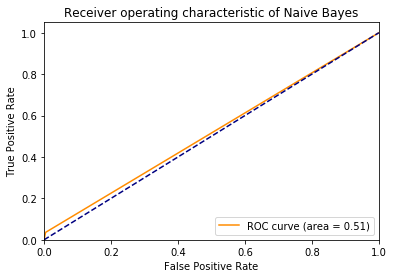

In [23]:
import matplotlib.pyplot as plt

nb_y_predict = model.transform(test_data)
nb_y_expected =  test_data
#['Discount Code']
print(type(nb_y_expected))
mvv_list = test_data.select('Discount Code').collect()
print(type(mvv_list))
nb_y_expected=mvv_list
mvv_list2 = nb_y_predict.select('prediction').collect()
nb_y_predict=mvv_list2
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Binarize the output - for th e ROC
bz_nb_y_expected = label_binarize(nb_y_expected, classes=[1,2,3,4])
bz_nb_y_predict = label_binarize(nb_y_predict, classes=[1,2,3,4])

n_classes = bz_nb_y_expected.shape[1]

# Compute ROC curve and ROC area for each class
nb_fpr = dict()
nb_tpr = dict()
nb_roc_auc = dict()
for i in range(n_classes):
    nb_fpr[i], nb_tpr[i], _ = roc_curve(bz_nb_y_expected[:, i], bz_nb_y_predict[:, i])
    nb_roc_auc[i] = auc(nb_fpr[i], nb_tpr[i])

# Compute micro-average ROC curve and ROC area
nb_fpr["micro"],nb_tpr["micro"], _ = roc_curve(bz_nb_y_expected.ravel(), bz_nb_y_predict.ravel())
nb_roc_auc["micro"] = auc(nb_fpr["micro"],  nb_tpr["micro"])

#plotting the statistics data
plt.figure()
lw =1.5
plt.plot(nb_fpr[2], nb_tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' %  nb_roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Naive Bayes')
plt.legend(loc="lower right")
plt.show()


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# the confusion matrix took from the internet
#this function will take confusion matrix, bool if to normalize the results or not, 
                                            #and the color that the matrix will show (defult is blue)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # if i signel normalize to be true so normalize the results
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # start plt the details 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #find how many classes to present in the list (1,2,3,4)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #format if normalize or not
    fmt = '.2f' if normalize else 'd'
    #trashold
    thresh = cm.max() / 2.
    #
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #Automatically adjust subplot parameters to give specified padding
    plt.tight_layout()
    plt.ylabel('Discount Code label')
    plt.xlabel('Predicted label')

In [15]:
#create confusion matrix for display
from sklearn.metrics import confusion_matrix
y_true = predictions.select("Discount Code")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)


Confusion matrix, without normalization


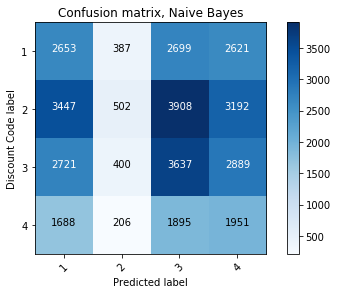

In [16]:
#print the currect matrix and plot it
plt.figure()
#test classes as lables
classes=[1,2,3,4]
plot_confusion_matrix(cnf_matrix, classes,
                      title='Confusion matrix, Naive Bayes')
plt.show()

In [17]:
# print TP,FP,FN when this function have been call
def printCM(cm, num):
    for i in range(num):
        print ('TP of {0} and {1} is {2}' ''.format(i+1 , i+1, cm[i][i]))
    print ('------------'*3)
    for j in range(num):   
        for i in range(num):
            if j != i:
                   print('FP of {0} and {1} is {2}'''.format(i+1, j+1, cm[j][i]))
    print ('------------'*3)
    for i in range(num):   
        for j in range(num):
            if j != i:
                   print('FN of {0} and {1} is {2}'''.format(i+1, j+1, cm[i][j]))
                    
printCM(cnf_matrix, 4)

TP of 1 and 1 is 2653
TP of 2 and 2 is 502
TP of 3 and 3 is 3637
TP of 4 and 4 is 1951
------------------------------------
FP of 2 and 1 is 387
FP of 3 and 1 is 2699
FP of 4 and 1 is 2621
FP of 1 and 2 is 3447
FP of 3 and 2 is 3908
FP of 4 and 2 is 3192
FP of 1 and 3 is 2721
FP of 2 and 3 is 400
FP of 4 and 3 is 2889
FP of 1 and 4 is 1688
FP of 2 and 4 is 206
FP of 3 and 4 is 1895
------------------------------------
FN of 1 and 2 is 387
FN of 1 and 3 is 2699
FN of 1 and 4 is 2621
FN of 2 and 1 is 3447
FN of 2 and 3 is 3908
FN of 2 and 4 is 3192
FN of 3 and 1 is 2721
FN of 3 and 2 is 400
FN of 3 and 4 is 2889
FN of 4 and 1 is 1688
FN of 4 and 2 is 206
FN of 4 and 3 is 1895


### Spark Decision Tree

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

labelIndexer = StringIndexer(inputCol="Discount Code", outputCol="indexedLabel").fit(final_data)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(final_data)

# Split the data into training and test sets (30% held out for testing)
(train_data, test_data) = final_data.randomSplit([0.7, 0.3])
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",minInfoGain=0)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_data)

# Make predictions.
predictions = model.transform(test_data)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))


+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       2.0|         1.0|[0.0,1.0,1.895734...|
|       2.0|         0.0|[0.0,1.0,2.465208...|
|       1.0|         3.0|[0.0,1.0,2.575897...|
|       1.0|         0.0|[0.0,1.0,2.614379...|
|       1.0|         1.0|[0.0,1.0,2.702702...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.607728 


<class 'pyspark.sql.dataframe.DataFrame'>
<class 'list'>


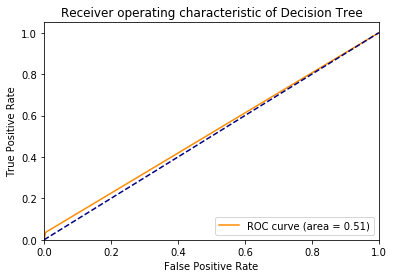

In [19]:
import matplotlib.pyplot as plt

nb_y_predict = model.transform(test_data)

#nb_y_predict = model.predict(x_test)
nb_y_expected =  test_data
#['Discount Code']
print(type(nb_y_expected))
mvv_list = test_data.select('Discount Code').collect()
print(type(mvv_list))

nb_y_expected=mvv_list

mvv_list2 = nb_y_predict.select('prediction').collect()

nb_y_predict=mvv_list2

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output - for th e ROC
bz_nb_y_expected = label_binarize(nb_y_expected, classes=[1,2,3,4])
bz_nb_y_predict = label_binarize(nb_y_predict, classes=[1,2,3,4])
n_classes = bz_nb_y_expected.shape[1]

# Compute ROC curve and ROC area for each class
nb_fpr = dict()
nb_tpr = dict()
nb_roc_auc = dict()
for i in range(n_classes):
    nb_fpr[i], nb_tpr[i], _ = roc_curve(bz_nb_y_expected[:, i], bz_nb_y_predict[:, i])
    nb_roc_auc[i] = auc(nb_fpr[i], nb_tpr[i])

# Compute micro-average ROC curve and ROC area
nb_fpr["micro"],nb_tpr["micro"], _ = roc_curve(bz_nb_y_expected.ravel(), bz_nb_y_predict.ravel())
nb_roc_auc["micro"] = auc(nb_fpr["micro"],  nb_tpr["micro"])

#plotting the statistics data
plt.figure()
lw =1.5
plt.plot(nb_fpr[2], nb_tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' %  nb_roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [20]:
y_true = predictions.select("Discount Code")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)


Confusion matrix, without normalization


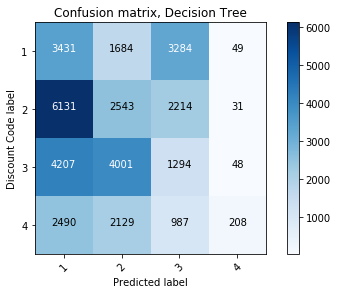

In [21]:
plt.figure()
classes=[1,2,3,4]
plot_confusion_matrix(cnf_matrix, classes,
                      title='Confusion matrix, Decision Tree')
plt.show()

In [22]:
printCM(cnf_matrix, 4)

TP of 1 and 1 is 3431
TP of 2 and 2 is 2543
TP of 3 and 3 is 1294
TP of 4 and 4 is 208
------------------------------------
FP of 2 and 1 is 1684
FP of 3 and 1 is 3284
FP of 4 and 1 is 49
FP of 1 and 2 is 6131
FP of 3 and 2 is 2214
FP of 4 and 2 is 31
FP of 1 and 3 is 4207
FP of 2 and 3 is 4001
FP of 4 and 3 is 48
FP of 1 and 4 is 2490
FP of 2 and 4 is 2129
FP of 3 and 4 is 987
------------------------------------
FN of 1 and 2 is 1684
FN of 1 and 3 is 3284
FN of 1 and 4 is 49
FN of 2 and 1 is 6131
FN of 2 and 3 is 2214
FN of 2 and 4 is 31
FN of 3 and 1 is 4207
FN of 3 and 2 is 4001
FN of 3 and 4 is 48
FN of 4 and 1 is 2490
FN of 4 and 2 is 2129
FN of 4 and 3 is 987
